In [4]:
from zipfile import ZipFile
file_name = "/content/flow.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done


In [3]:
mkdir -p models

In [ ]:
mkdir -p data

In [5]:
import torch
print(torch.cuda.is_available())

True


In [7]:
!python models/train.py

Epoch 1/10 - Loss: 0.004263
Epoch 2/10 - Loss: 0.001953
Epoch 3/10 - Loss: 0.001501
Epoch 4/10 - Loss: 0.001255
Epoch 5/10 - Loss: 0.001078
Epoch 6/10 - Loss: 0.000974
Epoch 7/10 - Loss: 0.000821
Epoch 8/10 - Loss: 0.000735
Epoch 9/10 - Loss: 0.000718
Epoch 10/10 - Loss: 0.000585


In [17]:
!python inference/anomaly_detector.py

Using 1500 flow frames
Total sequences: 149
Inference completed
Mean error: 0.0005506141
Std error : 0.00021234066
Threshold: 0.001187636
Abnormal events detected: 3
Figure(1200x400)


In [19]:
import torch
import torch.nn as nn

class ConvLSTMCell(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size=3):
        super().__init__()
        padding = kernel_size // 2

        self.hidden_channels = hidden_channels
        self.conv = nn.Conv2d(
            input_channels + hidden_channels,
            4 * hidden_channels,
            kernel_size,
            padding=padding
        )

    def forward(self, x, h, c):
        combined = torch.cat([x, h], dim=1)
        conv_out = self.conv(combined)

        i, f, o, g = torch.chunk(conv_out, 4, dim=1)

        i = torch.sigmoid(i)
        f = torch.sigmoid(f)
        o = torch.sigmoid(o)
        g = torch.tanh(g)

        c_next = f * c + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next


class ConvLSTMAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder: input = optical flow (3 channels)
        self.encoder = ConvLSTMCell(input_channels=3, hidden_channels=64)

        # Decoder: input = encoded feature maps (64 channels)
        self.decoder = ConvLSTMCell(input_channels=64, hidden_channels=64)

        # Final reconstruction layer
        self.output_conv = nn.Conv2d(64, 3, kernel_size=1)

    def forward(self, x):
        # x: (B, T, C, H, W)
        B, T, C, H, W = x.shape
        device = x.device

        h = torch.zeros(B, 64, H, W, device=device)
        c = torch.zeros(B, 64, H, W, device=device)

        encoded_states = []

        # ---- Encoder ----
        for t in range(T):
            h, c = self.encoder(x[:, t], h, c)
            encoded_states.append(h)

        # ---- Decoder ----
        decoded = []
        h_dec, c_dec = h, c

        for t in range(T):
            h_dec, c_dec = self.decoder(h_dec, h_dec, c_dec)
            out = self.output_conv(h_dec)
            decoded.append(out)

        decoded = torch.stack(decoded, dim=1)
        return decoded



Processing cam1...
Total sequences for cam1: 149
Mean error     : 0.0005506140878424048
Std error      : 0.00021234065934550017
Threshold      : 0.0011876360513269901
Abnormal events: 3


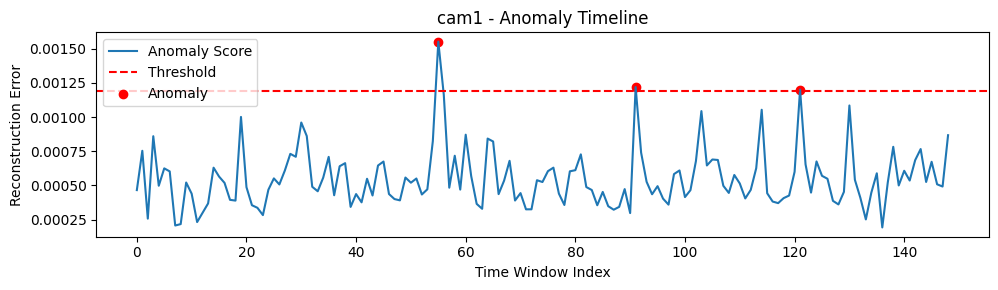


Processing cam2...
Total sequences for cam2: 149
Mean error     : 0.000556916173081845
Std error      : 0.00023841392248868942
Threshold      : 0.0012721579987555742
Abnormal events: 2


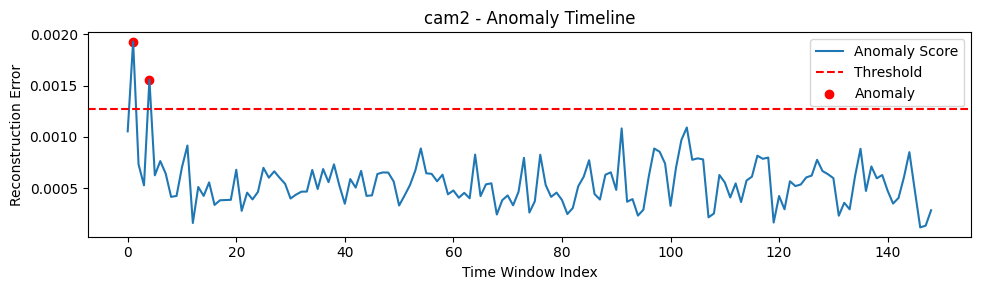


Processing cam3...
Total sequences for cam3: 149
Mean error     : 0.0006510174716822803
Std error      : 0.0003565616498235613
Threshold      : 0.0017207025084644556
Abnormal events: 5


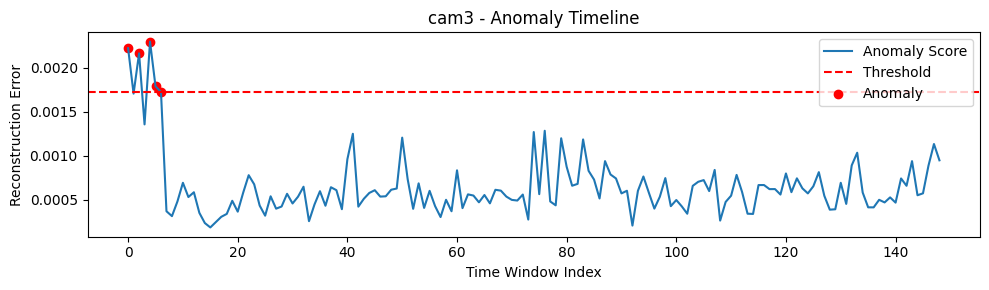


Processing cam4...
Total sequences for cam4: 149
Mean error     : 0.0007519851205870509
Std error      : 0.00035418252809904516
Threshold      : 0.001814532675780356
Abnormal events: 2


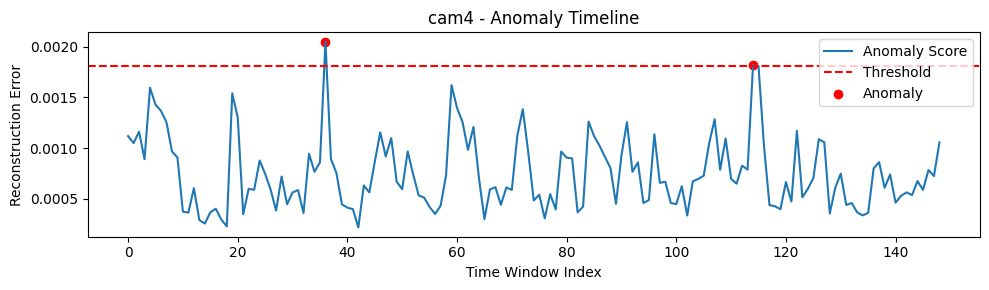


Saved results to results/all_camera_anomalies.json
Final camera anomalies:
{
  "cam1": [
    55.0,
    91.0,
    121.0
  ],
  "cam2": [
    1.0,
    4.0
  ],
  "cam3": [
    0.0,
    2.0,
    4.0,
    5.0,
    6.0
  ],
  "cam4": [
    36.0,
    114.0
  ]
}


In [22]:
import sys
import os
import cv2
import torch
import numpy as np
import json
import matplotlib.pyplot as plt

# -----------------------------
# Configuration
# -----------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

MODEL_PATH = "models/convlstm_autoencoder.pth"
FLOW_BASE_PATH = "data/flow"   # base folder
CAMERAS = ["cam1", "cam2", "cam3", "cam4"]

SEQUENCE_LENGTH = 10
STRIDE = 10
BATCH_SIZE = 4
MAX_FRAMES = 1500

FPS = 10  # effective FPS after sampling

# -----------------------------
# Load model ONCE
# -----------------------------
model = ConvLSTMAutoencoder().to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# -----------------------------
# Store all camera results here
# -----------------------------
all_camera_anomalies = {}

# -----------------------------
# Loop over cameras
# -----------------------------
for cam in CAMERAS:
    print(f"\nProcessing {cam}...")

    FLOW_PATH = os.path.join(FLOW_BASE_PATH, cam)
    flow_files = sorted(os.listdir(FLOW_PATH))[:MAX_FRAMES]

    sequences = []

    for i in range(0, len(flow_files) - SEQUENCE_LENGTH, STRIDE):
        seq = []
        for j in range(SEQUENCE_LENGTH):
            img_path = os.path.join(FLOW_PATH, flow_files[i + j])
            img = cv2.imread(img_path)

            if img is None:
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype("float32") / 255.0
            img = torch.from_numpy(img).permute(2, 0, 1)
            seq.append(img)

        if len(seq) == SEQUENCE_LENGTH:
            sequences.append(torch.stack(seq))

    if len(sequences) == 0:
        print(f"No valid sequences for {cam}")
        all_camera_anomalies[cam] = []
        continue

    sequences = torch.stack(sequences).to(DEVICE)
    print(f"Total sequences for {cam}: {sequences.shape[0]}")

    # -----------------------------
    # Batched inference
    # -----------------------------
    errors = []

    with torch.no_grad():
        for i in range(0, len(sequences), BATCH_SIZE):
            batch = sequences[i:i + BATCH_SIZE]
            recon = model(batch)
            batch_error = torch.mean((recon - batch) ** 2, dim=(1, 2, 3, 4))
            errors.extend(batch_error.cpu().numpy())

    errors = np.array(errors)

    mean_error = errors.mean()
    std_error = errors.std()
    threshold = mean_error + 3 * std_error

    abnormal_indices = [i for i, v in enumerate(errors) if v > threshold]
    abnormal_times = [i * STRIDE / FPS for i in abnormal_indices]

    all_camera_anomalies[cam] = abnormal_times

    print(f"Mean error     : {mean_error}")
    print(f"Std error      : {std_error}")
    print(f"Threshold      : {threshold}")
    print(f"Abnormal events: {len(abnormal_times)}")

    # -----------------------------
    # Optional: plot per camera
    # -----------------------------
    plt.figure(figsize=(10, 3))
    plt.plot(errors, label="Anomaly Score")
    plt.axhline(threshold, color="red", linestyle="--", label="Threshold")
    plt.scatter(
        abnormal_indices,
        [errors[i] for i in abnormal_indices],
        color="red",
        label="Anomaly"
    )
    plt.title(f"{cam} - Anomaly Timeline")
    plt.xlabel("Time Window Index")
    plt.ylabel("Reconstruction Error")
    plt.legend()
    plt.tight_layout()
    plt.show()

# -----------------------------
# Save FINAL combined JSON
# -----------------------------
os.makedirs("results", exist_ok=True)

final_output = {
    "fps": FPS,
    "stride": STRIDE,
    "sequence_length": SEQUENCE_LENGTH,
    "camera_anomalies": all_camera_anomalies
}

with open("results/all_camera_anomalies.json", "w") as f:
    json.dump(final_output, f, indent=2)

print("\nSaved results to results/all_camera_anomalies.json")
print("Final camera anomalies:")
print(json.dumps(all_camera_anomalies, indent=2))


In [24]:
TIME_WINDOW = 2.0   # seconds
MIN_CAMERAS = 2     # voting threshold

# -----------------------------
# Aggregate anomalies
# -----------------------------
all_events = []

for cam, times in all_camera_anomalies.items():
    for t in times:
        all_events.append((t, cam))

all_events.sort(key=lambda x: x[0])

global_alerts = []

for i, (time_i, cam_i) in enumerate(all_events):
    supporting_cams = {cam_i}

    for j, (time_j, cam_j) in enumerate(all_events):
        if i != j and abs(time_i - time_j) <= TIME_WINDOW:
            supporting_cams.add(cam_j)

    if len(supporting_cams) >= MIN_CAMERAS:
        global_alerts.append({
            "time": time_i,
            "cameras": list(supporting_cams)
        })

# Remove duplicates
unique_alerts = []
seen_times = set()

for alert in global_alerts:
    t = round(alert["time"])
    if t not in seen_times:
        unique_alerts.append(alert)
        seen_times.add(t)

# -----------------------------
# Output
# -----------------------------
print("GLOBAL CROWD ALERTS")
for alert in unique_alerts:
    print(
        f"Time: {alert['time']:.1f}s | Cameras: {alert['cameras']}"
    )


GLOBAL CROWD ALERTS
Time: 0.0s | Cameras: ['cam2', 'cam3']
Time: 1.0s | Cameras: ['cam2', 'cam3']
Time: 2.0s | Cameras: ['cam2', 'cam3']
Time: 4.0s | Cameras: ['cam2', 'cam3']
Time: 5.0s | Cameras: ['cam2', 'cam3']
Time: 6.0s | Cameras: ['cam2', 'cam3']
